# Code for running SiameseNet and TripletNet on BRACOL Dataset

***The code used in this notebook is mostly from [this](https://github.com/adambielski/siamese-triplet/). If you are interested in it, check it out, it is extremely well documented***

***Install libs***

In [8]:
#!pip install learn2learn
#!pip install efficientnet_pytorch
#!pip install transformers

from IPython.display import clear_output 
# clear_output()

print('Done!')

Done!


***Import some libs***

In [9]:
import sys
#sys.path.insert(0, '/content/drive/MyDrive/pg/siamese_triplet_net/src/')
#sys.path.insert(0,'C:/Users/Mey/Documents/pg-coffee-main/siamese_triplet_net/src/')
sys.path.insert(0,'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/')
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from dataloaders import get_train_transforms, get_val_transforms, get_triplet_dataloader
from networks import TripletNet 
from models import MobileNetv2
from losses import TripletLoss
from trainer import fit
import torchvision



***Define model hiperparams***

In [15]:
#from CustomViT import CustomViT
# model & optimizer & lr_scheduler

 
# مدل Siamese و ViT
embedding_net = MobileNetv2()
siamese_model = TripletNet(embedding_net=embedding_net)
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

#embedding_net = ViTEmbeddingNet()
#model = TripletNet(embedding_net=embedding_net)

#model = CustomViT(num_classes=15)

#====این قسمت به صورت موقت برای لود امبدینگ مدل آموزش داده شده قبلی بر روی پلنت ویلج به کار میرود
#import torch
#model = torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/siamese_NFNet_15Shot.h5",map_location=torch.device('cpu'))
#model.load_state_dict(torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/siamese_NFNet_15Shot.h5",map_location=torch.device('cpu')) )
#Wmodel.eval()
#============================
optimizer = torch.optim.SGD(siamese_model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_fn = TripletLoss(1.)
n_epochs=7 #100
device = torch.cuda.is_available()
if device:
    siamese_model.cuda()
    vit_model.cuda()

log_interval =10 # 100

# path to data
#path_data = '/content/drive/MyDrive/pg/dataset/'
path_data='C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'

# define siamese train and val loaders
# this loader is implemented for datasets in ImageFolder format (https://pytorch.org/vision/stable/datasets.html#imagefolder)
triplet_train_loader = get_triplet_dataloader(root=path_data + '/train/', batch_size=5, transforms=get_train_transforms())
triplet_val_loader = get_triplet_dataloader(root=path_data + '/val/', batch_size=5, transforms=get_val_transforms())

 

In [16]:
fit(triplet_train_loader, triplet_val_loader, siamese_model,  loss_fn, optimizer, lr_scheduler, n_epochs, device, log_interval)

Train: [0/225 (0%)]	Loss: 0.866711
Train: [50/225 (22%)]	Loss: 0.869844
Train: [100/225 (44%)]	Loss: 0.871947
Train: [150/225 (67%)]	Loss: 0.849314
Train: [200/225 (89%)]	Loss: 0.755677
Epoch: 1/7. Train set: Average loss: 0.8349
Epoch: 1/7. Validation set: Average loss: 0.7689
Estimated time of epoch: 1593.16 s
ETA:185.87 min
Train: [0/225 (0%)]	Loss: 0.864397
Train: [50/225 (22%)]	Loss: 0.766981
Train: [100/225 (44%)]	Loss: 0.746220
Train: [150/225 (67%)]	Loss: 0.731281
Train: [200/225 (89%)]	Loss: 0.729633
Epoch: 2/7. Train set: Average loss: 0.7323
Epoch: 2/7. Validation set: Average loss: 0.6318
Estimated time of epoch: 1347.56 s
ETA:134.76 min
Train: [0/225 (0%)]	Loss: 0.727711
Train: [50/225 (22%)]	Loss: 0.587557
Train: [100/225 (44%)]	Loss: 0.684530
Train: [150/225 (67%)]	Loss: 0.604947
Train: [200/225 (89%)]	Loss: 0.616772
Epoch: 3/7. Train set: Average loss: 0.6254
Epoch: 3/7. Validation set: Average loss: 0.5384
Estimated time of epoch: 1143.4 s
ETA:95.28 min
Train: [0/225 (

In [22]:
# from: https://github.com/avilash/pytorch-siamese-triplet/blob/master/tsne.py
import cv2
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
from torch.autograd import Variable
import os
import pandas as pd
import seaborn as sns
# استخراج ویژگی‌ها با استفاده از مدل Siamese
#def generate_embeddings(data_loader, model):
#    with torch.no_grad():
#        #device = 'cuda'
#        model.eval()
#        #model.to(device)
#        labels = None
#        embeddings = None
#        for batch_idx, data in tqdm(enumerate(data_loader)):
#            batch_imgs, batch_labels = data
#            batch_labels = batch_labels.numpy()
#           # batch_imgs = Variable(batch_imgs.to('cuda'))
#            batch_E = model.get_embedding(batch_imgs)
#            batch_E = batch_E.data.cpu().numpy()
#            embeddings = np.concatenate((embeddings, batch_E), axis=0) if embeddings is not None else batch_E
#            labels = np.concatenate((labels, batch_labels), axis=0) if labels is not None else batch_labels
#    return embeddings, labels
def generate_embeddings(data_loader, model):
    with torch.no_grad():
        #device = 'cuda'
        model.eval()
        #model.to(device)
        embeddings = []
        labels = []
        for batch_imgs, batch_labels in data_loader:
            if device:
                batch_imgs = batch_imgs.cuda()
            batch_E = model.get_embedding(batch_imgs)
            embeddings.append(batch_E.cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

def vis_tSNE(embeddings, labels, backbone='Convnet'):
    num_samples = embeddings.shape[0]
    X_embedded = TSNE(n_components=2).fit_transform(embeddings[0:num_samples, :])
    plt.figure(figsize=(16, 16))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#1fa7b4', '#fb7f0e', '#27a02c', '#da2758', '#a46abd','#af7bb4', '#fa7fbe', '#2baf2c', '#4f2d28', '#b4f7bd']
    labels_name = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight','Tomato__Target_Spot','Tomato__Tomato_mosaic_virus','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite']
    for i in range(16):
        inds = np.where(labels==i)[0]
        plt.scatter(X_embedded[inds,0], X_embedded[inds,1], alpha=.8, color=colors[i], s=200)
    # plt.title(f't-SNE', fontweight='bold', fontsize=24)
    plt.legend(labels_name, fontsize=30)
    plt.savefig(f'./tsne_{backbone}.png')



In [23]:
import torch
torch.save(siamese_model, "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/siamese_Mobilenet_15ShotViit.h5" )
#===قسمت زیر به صورت موقت غیر فعال شد آنرا برگردانیم
#model = torch.load("C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/siamese.h5",map_location=torch.device('cpu'))
#model.eval()
#======
path_data='C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


IndexError: list index out of range

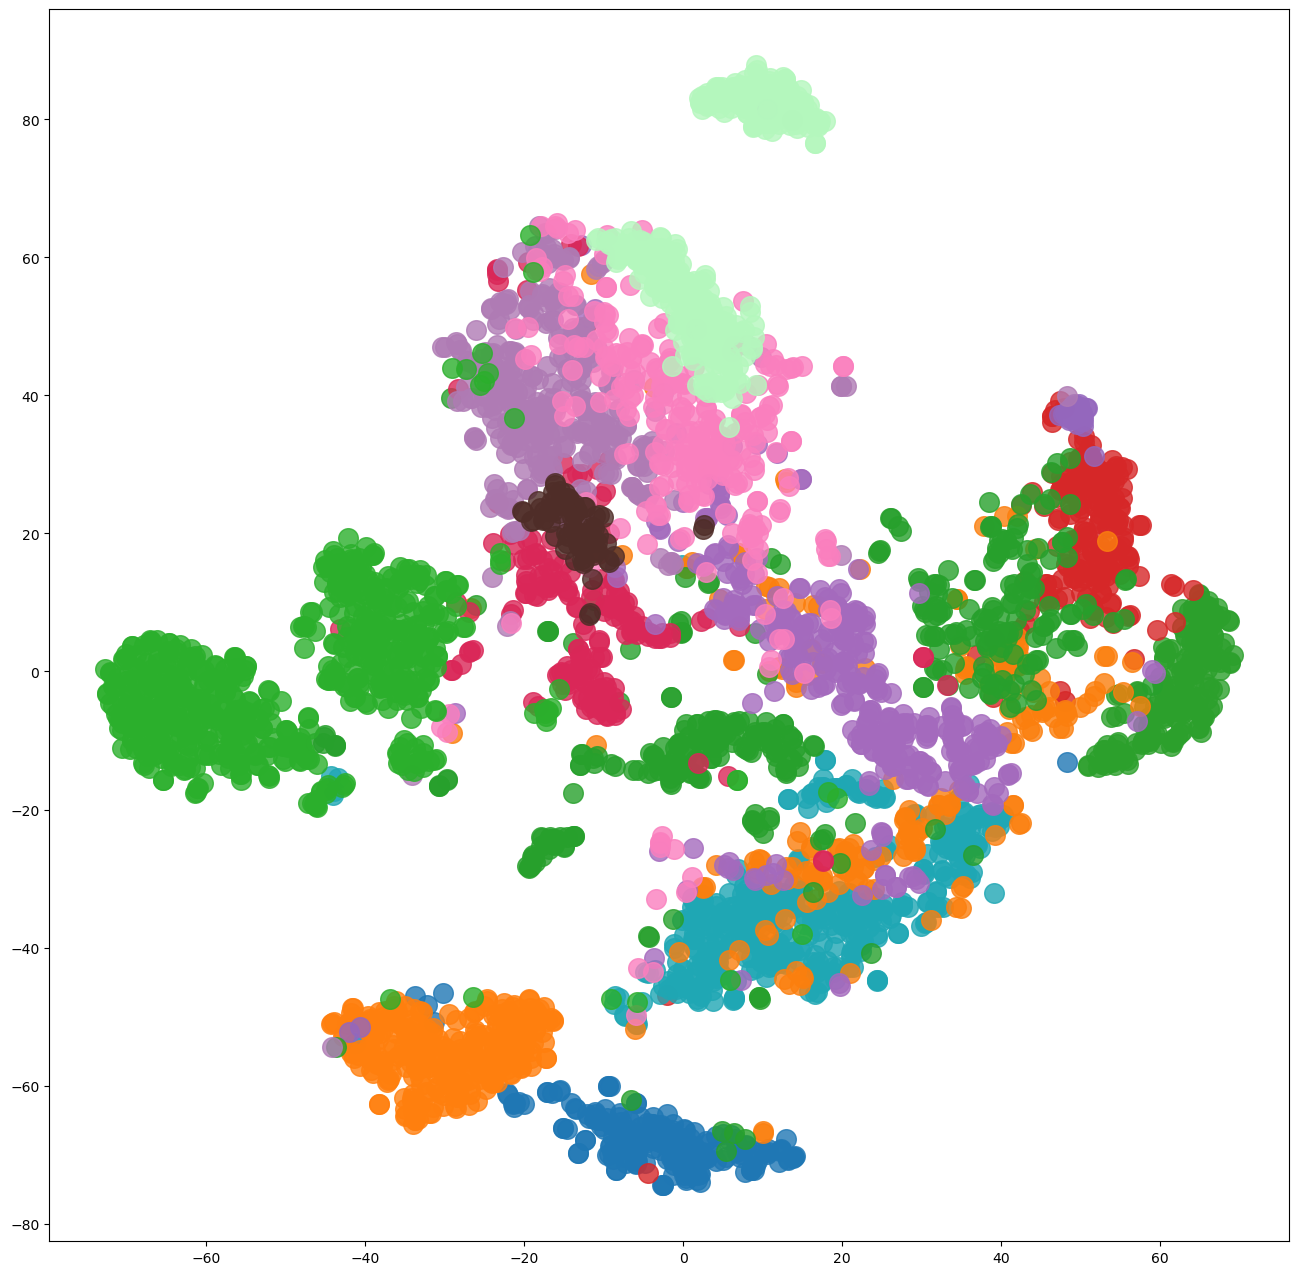

In [24]:
test_data = torchvision.datasets.ImageFolder(root=path_data + '/test/', transform=get_val_transforms())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

val_embeddings_cl, val_labels_cl = generate_embeddings(test_loader, siamese_model)
vis_tSNE(val_embeddings_cl, val_labels_cl)

In [30]:
train_data = torchvision.datasets.ImageFolder(root=path_data + '/train/', transform=get_val_transforms())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1)

test_data = torchvision.datasets.ImageFolder(root=path_data + '/test/', transform=get_val_transforms())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)
 

# استخراج ویژگی‌ها از داده‌های تست
test_embeddings, test_labels = generate_embeddings(test_loader, siamese_mode
 




AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [38]:

# تبدیل embedding‌ها به تصاویر مصنوعی
def embeddings_to_images(embeddings):
    images = []
    for embedding in embeddings:
        image = np.reshape(embedding, (1, 1, 1280))  # تبدیل به یک تصویر مصنوعی
        images.append(image)
    return np.array(images)



# طبقه‌بندی با استفاده از ViT
def classify_with_vit(embeddings, labels, vit_model, feature_extractor):
    vit_model.eval()
    predictions = []
   # images = embeddings_to_images(embeddings)
    with torch.no_grad():
         # تبدیل embeddings به تصاویر
        
        for embedding in embeddings :
            embedding = np.array(embedding)  # Ensure it's a NumPy array
            embedding = embedding.reshape((1280, 1, 1))
            #embedding = embedding.reshape(224, 224, 3)
            #mean = [0.485, 0.456, 0.406]  # Example mean values for each channel
            #std = [0.229, 0.224, 0.225] # Example std values for each channel
            inputs = feature_extractor(images=embedding, return_tensors="pt")#, do_normalize=True, image_mean=mean, image_std=std)
            if device:
                inputs = {k: v.cuda() for k, v in inputs.items()}
            outputs = vit_model(**inputs)
            logits = outputs.logits
            predicted_class = logits.argmax(-1).item()
            predictions.append(predicted_class)
    return predictions

# پیش‌بینی با ViT
predictions = classify_with_vit(test_embeddings, test_labels, vit_model, feature_extractor)

 

# ارزیابی نتایج
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
    

ValueError: mean must have 1 elements if it is an iterable, got 3